In [111]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader

In [112]:
import gc

gc.collect()

11221

In [113]:
def split(X, y, seed, z=None, train_size=0.7, test_size=0.3, val_size=0.2):
    X_val = None
    y_val = None
    Z_train, Z_val, Z_test = None, None, None
    if train_size is None and test_size is None:
        raise AttributeError()
    elif train_size is None:
        train_size = 1. - test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                        train_size=train_size)
    if z is not None:
        Z_train, Z_test = train_test_split(z, stratify=y, random_state=seed, shuffle=True, train_size=train_size)
    if val_size is not None:
        if z is not None:
            Z_train, Z_val = train_test_split(Z_train, stratify=y_train, random_state=seed, shuffle=True,
                                              test_size=val_size)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=seed,
                                                          shuffle=True, test_size=val_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test)



In [114]:
def get_dataset(
        df: str | pd.DataFrame = 'dataset/EDOS_1M_balanced.pkl',
        seed=0
):
    df = df
    if isinstance(df, str):
        if df.endswith('pkl'):
            df = pd.read_pickle(df)
        else:
            df = pd.read_csv(df)
    groups = []
    labels = []
    confidence = []
    for name, group in df.groupby(by='eb+_emot'):
        group = group.reset_index(drop=True)
        groups.append(group.loc[:, 'uttr'])
        confidence.append(group.loc[:, 'label_confidence'])
        labels.append(group.loc[:, 'eb+_emot'])

    groups = np.array(groups, dtype=str)
    labels = np.array(labels, dtype=str)

    confidence = np.array(confidence, dtype=np.float32)
    return groups, labels, confidence


In [115]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [116]:
groups, labels, confidence = get_dataset()

In [117]:

unique = np.unique(labels.flatten())
emotions_to_category = {key: value for key, value in zip(unique, range(len(unique)))}
category_to_emotion = {key: value for key, value in zip(range(len(unique)), unique)}


def label_convert(label):
    return emotions_to_category[label]

In [118]:
labels = np.vectorize(label_convert)(labels)

In [119]:
class OurDataset(Dataset):
    def __init__(self, X, y, z):
        self.X = X
        self.y = y
        self.z = z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item], self.z[item]

In [120]:
seed = 0
(X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test) = split(groups.flatten(),
                                                                                       labels.flatten(), seed,
                                                                                       confidence.flatten())
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(196950,)
(105510,)
(49238,)


In [121]:
train_dataset = OurDataset(X_train, y_train, Z_train)
test_dataset = OurDataset(X_test, y_test, Z_test)
val_dataset = OurDataset(X_val, y_val, Z_val)

In [122]:
def collate_fn(batch):
    global tokenizer
    x, y, z = [], [], []
    for x1, y1, z1 in batch:
        x.append(x1)
        y.append(y1)
        z.append(z1)
    batch = tokenizer(x, padding=True, return_tensors='pt')
    y = torch.as_tensor(y)
    z = torch.as_tensor(z, dtype=torch.float32)
    return batch, y, z

    # print(x)

In [149]:
generator = torch.Generator().manual_seed(0)
sampling_train = torch.utils.data.RandomSampler(train_dataset, num_samples=10000, replacement=False,
                                                generator=generator)
sampling_test = torch.utils.data.RandomSampler(test_dataset, num_samples=1000, replacement=False, generator=generator)
sampling_val = torch.utils.data.RandomSampler(val_dataset, num_samples=1000, replacement=False, generator=generator)
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, sampler=sampling_train)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, sampler=sampling_test)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, sampler=sampling_val)

In [150]:
class Agglomerate:
    def __init__(self, device):
        self.device = device

    def __call__(self, *args, **kwargs):
        pass


class Concat(Agglomerate):
    def __init__(self, device, name='bert-base-uncased'):
        super(Concat, self).__init__(device)
        config = AutoConfig.from_pretrained(name)
        config.update({"output_hidden_states": True})
        self.encoder = AutoModel.from_pretrained(name, config=config)
        self.encoder.to(device)
        self.encoder.eval()
        for param in self.encoder.parameters(recurse=True):
            param.requires_grad = False

    def __call__(self, batch):
        with torch.no_grad():
            x = self.encoder(batch['input_ids'].to(self.device),
                             batch['attention_mask'].to(self.device))  # TODO: check against ** batch
            hidden_states = torch.stack(x["hidden_states"])
            concatenated = torch.cat((hidden_states[-1], hidden_states[-2], hidden_states[-3], hidden_states[-4]), -1)
            concatenated = concatenated[:, 0]
        return concatenated


class WeightedPooling(Agglomerate):
    def __init__(self, device, start_layer=4, name='bert-base-uncased'):
        super(WeightedPooling, self).__init__(device)
        config = AutoConfig.from_pretrained(name)
        config.update({"output_hidden_states": True})
        self.encoder = AutoModel.from_pretrained(name, config=config)
        self.encoder.to(device)
        self.encoder.eval()
        for param in self.encoder.parameters(recurse=True):
            param.requires_grad = False
        self.start_layer = start_layer

    def __call__(self, batch):
        with torch.no_grad():
            x = self.encoder(batch['input_ids'].to(self.device),
                             batch['attention_mask'].to(self.device))  # TODO: check against ** batch
            hidden_states = torch.stack(x["hidden_states"])
            hidden_states = hidden_states[self.start_layer:, :, :, :]
        return hidden_states


class EmotionClassifierConcat(nn.Module):
    def __init__(self, output_size, device, hidden_layers, activation_fn=nn.ReLU, dropout_value=0.):
        super(EmotionClassifierConcat, self).__init__()
        self.classification = nn.Sequential(
        )
        for i in range(len(hidden_layers)):
            curr = hidden_layers[i]
            if i == 0:
                self.classification.append(nn.LazyLinear(curr))
                self.classification.append(activation_fn())
                if dropout_value > 0:
                    self.classification.append(nn.Dropout(dropout_value))
                continue
            prev = hidden_layers[i - 1]
            self.classification.append(nn.Linear(prev, curr))
            self.classification.append(activation_fn())
            if dropout_value > 0:
                self.classification.append(nn.Dropout(dropout_value))

        self.classification.append(nn.Linear(hidden_layers[-1], output_size))
        # self.classification.append(nn.Softmax(dim=-1))

        self.device = device

    def forward(self, concatenated):
        return self.classification(concatenated)


class EmotionClassifierWeightedPooling(nn.Module):
    def __init__(self,
                 output_size,
                 device,
                 hidden_layers,
                 start_layer,
                 activation_fn=nn.ReLU,
                 dropout_value=0.,
                 total_hidden_states=13
                 ):
        super(EmotionClassifierWeightedPooling, self).__init__()

        self.start_layer = start_layer
        self.classification = nn.Sequential(
        )
        for i in range(len(hidden_layers)):
            curr = hidden_layers[i]
            if i == 0:
                self.classification.append(nn.LazyLinear(curr))
                self.classification.append(activation_fn())
                if dropout_value > 0:
                    self.classification.append(nn.Dropout(dropout_value))
                continue
            prev = hidden_layers[i - 1]
            self.classification.append(nn.Linear(prev, curr))
            self.classification.append(activation_fn())
            if dropout_value > 0:
                self.classification.append(nn.Dropout(dropout_value))

        self.classification.append(nn.Linear(hidden_layers[-1], output_size))
        # self.classification.append(nn.Softmax(dim=-1))

        self.device = device

        # wieght # 64, 61, 768
        self.layer_weight = nn.Parameter(
            torch.full(size=(total_hidden_states - start_layer, 1, 1, 1), fill_value=1, dtype=torch.float32,
                       requires_grad=True))

    def forward(self, hidden_states):
        with torch.no_grad():
            weight_factor = self.layer_weight.expand(hidden_states.size())
            weighted_average = (weight_factor * hidden_states).sum(dim=0) / self.layer_weight.sum()
        return self.classification(weighted_average[:, 0])



In [165]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy().argmax(-1)
    accuracy = accuracy_score(y_true, y_pred)
    f1_score_value = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1_score_value


def decode(input_, y_true, y_pred, confidence, top_5=True):
    global tokenizer, category_to_emotion

    input_ = input_[0].detach().cpu()
    y_true = y_true[0].detach().cpu().item()
    y_pred = y_pred[0].detach().cpu().numpy()
    true_confidence = confidence[0]
    pred_confidence = y_pred.max()
    top_5_emotions = None
    if top_5:
        index = y_pred.argsort()[-5:]
        top_5_emotions = [category_to_emotion[i] for i in index]
    y_pred = y_pred.argmax()
    input_ = tokenizer.decode(input_)
    y_true = category_to_emotion[y_true]
    y_pred = category_to_emotion[y_pred]
    return input_, y_true, y_pred, true_confidence, pred_confidence, top_5_emotions


def conv_fn(x):
    global category_to_emotion
    return category_to_emotion[x]


def top(y_true, y_pred, top_n=5):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argsort(y_pred, axis=-1)[:, -5:]
    return np.mean(np.isin(y_true[:, np.newaxis], y_pred))



[[ True]
 [False]
 [False]
 [ True]]


In [167]:
from torchsummary import summary
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")


class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.best_val = np.inf
        self.counter = 0

    def __call__(self, val: float):
        save = False
        if val < self.best_val:
            self.counter = 0
            self.best_val = val
            save = True
        else:
            self.counter += 1
        return self.counter >= self.patience, save


class Trainer:
    def __init__(self,
                 model: EmotionClassifierConcat | EmotionClassifierWeightedPooling,
                 agglomerate: Agglomerate,
                 model_name: str,
                 device,
                 dataloaders: tuple[DataLoader, DataLoader, DataLoader | None],
                 optimizer=torch.optim.AdamW,
                 scheduler=None,
                 lr: float = 1e-3,
                 output_dir: str = './RESULTS',
                 patience: int = 10,
                 clipping_norm=0.1,
                 verbose=0,
                 ):
        self.model_name = model_name
        self.agglomerate = agglomerate
        self.device = device
        self.output_dir = output_dir

        self.model = model
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        self.scheduler = scheduler
        self.verbose = verbose
        self.train_loader, self.test_loader, self.val_loader = dataloaders

        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

        self.early_stopper = EarlyStopping(patience)
        self.clipping_norm = clipping_norm

        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

    def process_data(self, batch):
        batch = self.agglomerate(batch)
        return self.model.forward(batch)

    def print_architecture(self, batch_size=64):  #TODO: NOT WORKING
        print(summary(self.model.classification, input_size=(3072,), batch_size=batch_size, device=self.device))

    def reset_params(self):
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

    def draw_training_metrics(self, save=True, format='pdf', figsize=(16, 8), step=1):
        if len(self.train_loss) == 0:
            return
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Training metrics')
        axs[0].plot(self.train_loss, label='Train')
        axs[0].plot(self.validation_loss, label='Validation')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].set_xticks(np.arange(0, len(self.train_loss), step))
        axs[0].legend()

        axs[1].plot(self.train_accuracy, label='Train')
        axs[1].plot(self.validation_accuracy, label='Validation')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_xticks(np.arange(0, len(self.train_accuracy), step))
        axs[1].legend()

        axs[2].plot(self.train_f1_score, label='Train')
        axs[2].plot(self.validation_f1_score, label='Validation')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('F1 Score')
        axs[2].set_xticks(np.arange(0, len(self.train_f1_score), step))
        axs[2].legend()

        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_train_metrics.{format}', bbox_inches='tight')
        plt.show()

    def draw_top_5(self, save=True, format='pdf', figsize=(16, 8), step=1):
        fig = plt.figure(figsize=figsize)
        plt.plot(self.validation_is_in_top_5)
        plt.xlabel('Epochs')
        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_top_5.{format}', bbox_inches='tight')
        plt.show()

    def train_model(self, epochs):
        self.reset_params()
        loader_length = len(self.train_loader)
        for ep in range(1, epochs + 1):
            print('#' * 20, ep, '#' * 20)
            self.model.train()
            loss_ep: float = 0.
            accuracy_ep: float = 0.
            f1_score_ep: float = 0.
            for batch, labels, confidence, in tqdm(self.train_loader):
                out = self.process_data(batch)
                self.optimizer.zero_grad()
                loss = self.loss_fn(out, labels.to(self.device))
                loss.backward()
                if self.clipping_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.clipping_norm)
                self.optimizer.step()
                loss_ep += loss.item()
                with torch.no_grad():
                    a, f1 = compute_metrics(labels, out)
                    accuracy_ep += a
                    f1_score_ep += f1
            loss_ep /= loader_length
            accuracy_ep /= loader_length
            f1_score_ep /= loader_length
            self.train_loss.append(loss_ep)
            self.train_accuracy.append(accuracy_ep)
            self.train_f1_score.append(f1_score_ep)
            print(f'TRAIN LOSS: {loss_ep:.5f} ; ACCURACY: {accuracy_ep:.5f} ; F1: {f1_score_ep:.5f}')
            if self.val_loader is not None:
                if self.validate():
                    break

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            loss_val = 0
            accuracies = 0
            f1_scores = 0
            length_val_dataloader = len(self.val_loader)
            top_5_ep = 0.
            for idx, (batch, labels, confidence) in enumerate(self.val_loader):
                out = self.process_data(batch)
                loss = self.loss_fn(out, labels.to(self.device))
                loss_val += loss.item()
                out = nn.functional.softmax(out, dim=-1)
                ac, f1 = compute_metrics(labels, out)
                accuracies += ac
                f1_scores += f1
                top_5_ep += top(labels, out)
                if self.verbose:
                    if idx == length_val_dataloader - 1:
                        input_, y_true, y_pred, c_true, c_pred, top_5_emotions = decode(batch['input_ids'], labels, out,
                                                                                        confidence)

            loss_val /= length_val_dataloader
            accuracies /= length_val_dataloader
            f1_scores /= length_val_dataloader
            top_5_ep /= length_val_dataloader
            self.validation_loss.append(loss_val)
            self.validation_accuracy.append(accuracies)
            self.validation_f1_score.append(f1_scores)
            self.validation_is_in_top_5.append(top_5_ep)
            print(
                f'VAL   LOSS: {loss_val:.5f} ; ACCURACY: {accuracies:.5f} ; F1: {f1_scores:.5f} ; top 5: {top_5_ep:.5f}')
            if self.verbose:
                print('INPUT:', input_.replace('[PAD]', '').rstrip())
                print('TRUE LABEL:', y_true, 'conf:', f'{c_true:.5f}')
                print('PREDICTED_LABEL', y_pred, 'conf', f'{c_pred:.5f}')
                if top_5_emotions is not None:
                    print(f'TOP 5: {list(reversed(top_5_emotions))}')
            break_, save_ = self.early_stopper(loss_val)
            if save_:
                torch.save(self.model.state_dict(), f'{self.output_dir}/{self.model_name}.pt')
        return break_

def load_model(model, path: str):
    if not path.endswith('.pt'):
        path += '.pt'
    model.load_state_dict(torch.load(path))





In [168]:
OUTPUT_SIZE = len(emotions_to_category)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
hidden_layers = [128, 64]

# model = EmotionClassifierConcat(output_size=OUTPUT_SIZE,
#                                 device=DEVICE,
#                                 hidden_layers=hidden_layers)

model = EmotionClassifierWeightedPooling(
    output_size=OUTPUT_SIZE,
    device=DEVICE,
    hidden_layers=hidden_layers,
    start_layer=4
)
agglomerate = WeightedPooling(device=DEVICE, start_layer=4)

/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [169]:
model_name = 'test1'
output_size = len(emotions_to_category)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)
dataloaders = train_dataloader, test_dataloader, val_dataloader
trainer = Trainer(
    model,
    agglomerate=agglomerate,
    model_name=model_name,
    device=device,
    dataloaders=dataloaders,
    verbose=1
)

mps


In [155]:
# trainer.print_architecture(64)

In [156]:
trainer.train_model(20)

#################### 1 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 3.56792 ; ACCURACY: 0.07096 ; F1: 0.04081
VAL   LOSS: 3.32074 ; ACCURACY: 0.12480 ; F1: 0.09269 ; top 5: 0.81094
INPUT: [CLS] what on earth could you be expecting? [SEP]
TRUE LABEL: surprised conf: 0.64400
PREDICTED_LABEL questioning conf 0.11047
TOP 5: ['questioning', 'excited', 'furious', 'angry', 'suggesting']
#################### 2 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 3.14740 ; ACCURACY: 0.16670 ; F1: 0.13647
VAL   LOSS: 2.94564 ; ACCURACY: 0.20508 ; F1: 0.18534 ; top 5: 0.97754
INPUT: [CLS] i messed up, harry. i messed it all up. [SEP]
TRUE LABEL: guilty conf: 0.58299
PREDICTED_LABEL ashamed conf 0.07220
TOP 5: ['ashamed', 'neutral', 'surprised', 'sympathizing', 'sad']
#################### 3 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 2.82137 ; ACCURACY: 0.22383 ; F1: 0.19915
VAL   LOSS: 2.64613 ; ACCURACY: 0.27910 ; F1: 0.26012 ; top 5: 0.99707
INPUT: [CLS] nothing anymore. i was fired. [SEP]
TRUE LABEL: devastated conf: 0.56908
PREDICTED_LABEL devastated conf 0.21734
TOP 5: ['devastated', 'sad', 'ashamed', 'lonely', 'angry']
#################### 4 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 2.61243 ; ACCURACY: 0.26393 ; F1: 0.24276
VAL   LOSS: 2.54340 ; ACCURACY: 0.29082 ; F1: 0.26969 ; top 5: 0.99648
INPUT: [CLS] almost shot him. [SEP]
TRUE LABEL: guilty conf: 0.90212
PREDICTED_LABEL ashamed conf 0.22093
TOP 5: ['ashamed', 'disgusted', 'annoyed', 'surprised', 'terrified']
#################### 5 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 2.48357 ; ACCURACY: 0.29289 ; F1: 0.27647
VAL   LOSS: 2.46854 ; ACCURACY: 0.31055 ; F1: 0.28650 ; top 5: 0.99023
INPUT: [CLS] you don't actually know if he read all of it. maybe he's telling the truth. [SEP]
TRUE LABEL: apprehensive conf: 0.43369
PREDICTED_LABEL apprehensive conf 0.20185
TOP 5: ['apprehensive', 'hopeful', 'neutral', 'confident', 'afraid']
#################### 6 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 2.38831 ; ACCURACY: 0.31369 ; F1: 0.29790
VAL   LOSS: 2.36975 ; ACCURACY: 0.31875 ; F1: 0.29922 ; top 5: 0.99902
INPUT: [CLS] it feels so good... the sun lower than dope. [SEP]
TRUE LABEL: content conf: 0.43387
PREDICTED_LABEL joyful conf 0.15846
TOP 5: ['joyful', 'impressed', 'sentimental', 'nostalgic', 'proud']
#################### 7 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

TRAIN LOSS: 2.31164 ; ACCURACY: 0.33668 ; F1: 0.31949
VAL   LOSS: 2.22619 ; ACCURACY: 0.35840 ; F1: 0.34598 ; top 5: 0.99121
INPUT: [CLS] in the stove, we keep fire burning always. the goons will not feel like moving it. [SEP]
TRUE LABEL: annoyed conf: 0.51363
PREDICTED_LABEL apprehensive conf 0.19005
TOP 5: ['apprehensive', 'trusting', 'afraid', 'confident', 'anxious']
#################### 8 ####################


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trainer.draw_training_metrics(save=False, figsize=(18, 6))

In [ ]:
trainer.draw_top_5(save=False)

In [147]:
import sys
import time


def dialogue(model: EmotionClassifierWeightedPooling | EmotionClassifierConcat, agglomerate: Agglomerate,
             deterministic=True):
    global category_to_emotion
    model.eval()
    with torch.no_grad():
        while True:
            user_text = input('ENTER SENTENCE:')
            if user_text.lower() == 'exit' or len(user_text) == 0:
                print('BYE!')
                return
            print(f'USER: {user_text}')
            assert isinstance(user_text, str)
            batch = tokenizer(user_text, padding=True, return_tensors='pt')
            batch = agglomerate(batch)
            prediction = model.forward(batch)

            prediction = nn.functional.softmax(prediction, dim=-1).cpu().numpy().flatten()
            if deterministic:
                predicated_label = prediction.argmax()
                probability = np.max(prediction)
                predicated_label = category_to_emotion[predicated_label]
                top_5_prediction = prediction.argsort()[-5:]
                top_5_probability = prediction[top_5_prediction][::-1]
                top_5 = np.vectorize(conv_fn)(top_5_prediction)[::-1]
                dictionary = {key: value for key, value in zip(top_5, top_5_probability)}
                print(f'BOT: {predicated_label} with prob: {probability}')
                print(f'TOP 5: {dictionary}')
            time.sleep(2)

In [176]:
load_model(model, './RESULTS/test1.pt')

In [181]:
dialogue(model, agglomerate)

USER: You are a monster!
BOT: angry with prob: 0.22522132098674774
TOP 5: {'angry': 0.22522132, 'devastated': 0.1858257, 'disgusted': 0.14554246, 'impressed': 0.07619001, 'ashamed': 0.0477977}
BYE!


In [178]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def test_model(model: EmotionClassifierWeightedPooling | EmotionClassifierConcat, agglomerate: Agglomerate,
               deterministic=True):
    global category_to_emotion
    model.eval()
    with torch.no_grad():
        real_labels = []
        out_labels = []
        accuracies = []
        f1_scores = []
        top_5_ = []
        for idx, (batch, labels, confidence) in enumerate(test_dataloader):
            batch = agglomerate(batch)
            out = model.forward(batch)
            ac, f1 = compute_metrics(labels, out)
            accuracies.append(ac)
            f1_scores.append(f1)
            real_labels.append(labels.cpu().numpy())
            out = nn.functional.softmax(out, -1)
            top_5_.append(top(labels, out))
            out_labels.append(out.argmax(-1).cpu().numpy())

    return real_labels, out_labels, accuracies, f1_scores, top_5_





In [179]:
real_labels, out_labels, accuracies, f1_scores, top_5_ = test_model(model, agglomerate)

In [180]:
print(f'MEAN ACCURACIES : {np.mean(accuracies)}')
print(f'MEAN F1 SCORE   : {np.mean(f1_scores)}')
print(f'MEAN TOP 5 SCORE: {np.mean(top_5_)}')


MEAN ACCURACIES : 0.301171875
MEAN F1 SCORE   : 0.28201698908730155
MEAN TOP 5 SCORE: 0.9990234375


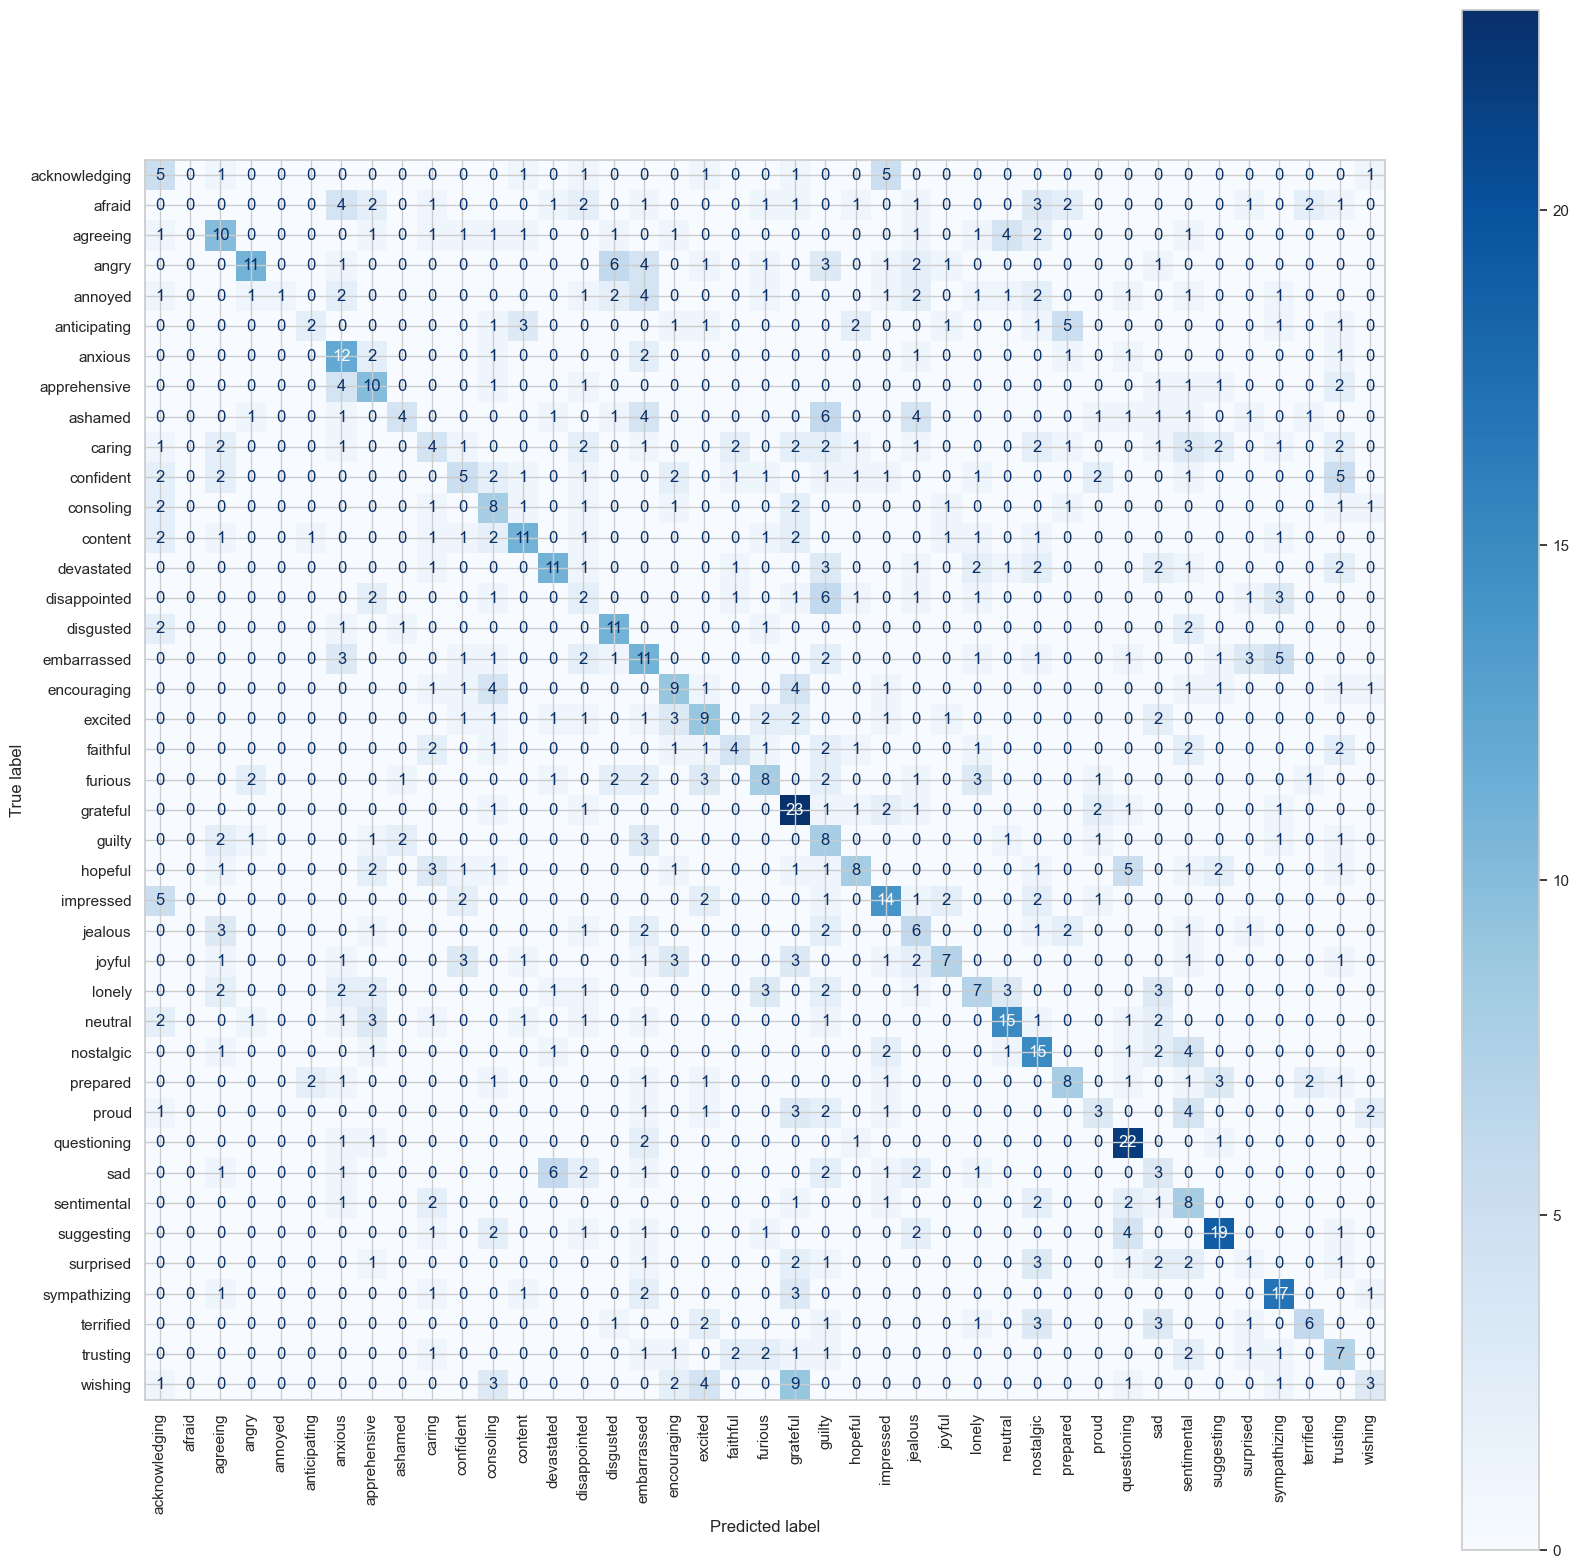

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

fig, ax = plt.subplots(figsize=(20, 20))
x = list(map(lambda x: category_to_emotion[x], np.concatenate(real_labels, axis=0)))
y = list(map(lambda x: category_to_emotion[x], np.concatenate(out_labels, axis=0)))
# cm = confusion_matrix(np.concatenate(real_labels, axis=0), np.concatenate(out_labels, axis=0))
disp = ConfusionMatrixDisplay.from_predictions(x, y,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

In [182]:
print(classification_report(x, y))

               precision    recall  f1-score   support

acknowledging       0.20      0.31      0.24        16
       afraid       0.00      0.00      0.00        24
     agreeing       0.36      0.37      0.36        27
        angry       0.65      0.34      0.45        32
      annoyed       1.00      0.04      0.08        23
 anticipating       0.40      0.11      0.17        19
      anxious       0.32      0.57      0.41        21
 apprehensive       0.34      0.48      0.40        21
      ashamed       0.50      0.14      0.22        28
       caring       0.19      0.12      0.15        32
    confident       0.29      0.17      0.22        29
    consoling       0.25      0.40      0.31        20
      content       0.52      0.41      0.46        27
   devastated       0.48      0.39      0.43        28
 disappointed       0.09      0.10      0.09        20
    disgusted       0.44      0.61      0.51        18
  embarrassed       0.23      0.33      0.28        33
  encoura

/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi